/home/octoopt/anaconda3/envs/octo/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


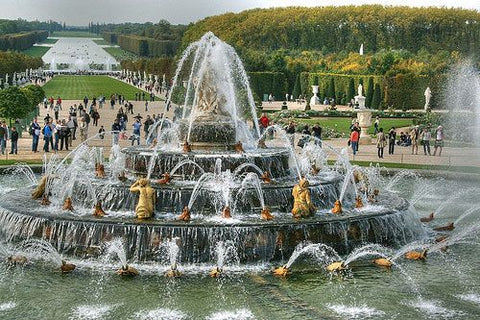

In [1]:
import requests
import torch
from PIL import Image

# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load sample image
image_url = "https://cdn.shopify.com/s/files/1/0910/2272/files/vers_large.jpg"
image_response = requests.get(image_url)

raw_image = Image.open(requests.get(image_url, stream = True).raw)
raw_image

In [3]:
from lavis.models import load_model_and_preprocess

model, vis_processors, txt_processors = load_model_and_preprocess(name="blip2_feature_extractor", 
                                                                  model_type="pretrain", 
                                                                  is_eval=True, 
                                                                  device=device
                                                                  )

caption = "a large fountain spewing water into the air"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
text_input = txt_processors["eval"](caption)
sample = {"image": image, "text_input": [text_input]}

features_multimodal = model.extract_features(sample)
print(features_multimodal.multimodal_embeds.shape)
# torch.Size([1, 12, 768]), use features_multimodal[:,0,:] for multimodal classification tasks

features_image = model.extract_features(sample, mode="image")
features_text = model.extract_features(sample, mode="text")
print(features_image.image_embeds.shape)
# torch.Size([1, 197, 768])
print(features_text.text_embeds.shape)
# torch.Size([1, 12, 768])

# low-dimensional projected features
print(features_image.image_embeds_proj.shape)
# torch.Size([1, 197, 256])
print(features_text.text_embeds_proj.shape)
# torch.Size([1, 12, 256])
similarity = features_image.image_embeds_proj[:,0,:] @ features_text.text_embeds_proj[:,0,:].t()
print(similarity)
# tensor([[0.2622]])

/home/octoopt/anaconda3/envs/octo/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/octoopt/anaconda3/envs/octo/lib/python3.10/site-packages/lavis/models/eva_vit.py:433: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

torch.Size([1, 32, 768])
torch.Size([1, 32, 768])
torch.Size([1, 12, 768])
torch.Size([1, 32, 256])
torch.Size([1, 12, 256])
tensor([[0.2639]])


In [4]:
for i in range(torch.cuda.device_count()): print(torch.cuda.get_device_properties(i).name)

Quadro P2000
